
# Wine quality prediction with a Dense Network (DNN)

Inspired by the [WineQuality Fidle tutorial](https://fidle.cnrs.fr/w3/)


## 0. Parameters

In [13]:
dataset_name = 'winequality_red.csv'
hidden_size = 64
num_epochs = 100
num_tests = 10

## 1. Imports


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## 2. Retrieve data

In [4]:
data = pd.read_csv(f"data/{dataset_name}", header=0, sep=';')
display(data.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 3. Preparing the data

In [5]:
# Shuffle and split the data
data       = data.sample(frac=1., axis=0)
data_train = data.sample(frac=0.8, axis=0)
data_test  = data.drop(data_train.index)

# Split the data into input (x) and target (y)
x_train = data_train.drop('quality', axis=1)
y_train = data_train['quality']
x_test  = data_test.drop('quality', axis=1)
y_test  = data_test['quality']

# Normalize the data
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
x_test  = torch.tensor(x_test.values,  dtype=torch.float32)
y_test  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1, 1)

# Create the data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset  = TensorDataset(x_test, y_test)
test_loader   = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 4. Build the model

In [6]:
# Define the model
class Model(nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super(Model, self).__init__()
		self.relu = nn.ReLU()
		self.fc1 = nn.Linear(input_size, hidden_size)
		self.fc2 = nn.Linear(hidden_size, hidden_size)
		self.fc3 = nn.Linear(hidden_size, output_size)

	def forward(self, x):
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.relu(x)
		x = self.fc3(x)
		return x

# Create the model
model = Model(x_train.shape[1], hidden_size, 1)
display(model)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

Model(
  (relu): ReLU()
  (fc1): Linear(in_features=11, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

## 5. Train the model

In [7]:
# Create a directory to save the model
os.makedirs('./models',   mode=0o750, exist_ok=True)
save_dir = f"./models/{dataset_name.split('.')[0]}_model.pth"

best_val_mae = float('inf')
train_losses = []
train_maes   = []
train_mses   = []
test_losses  = []
test_maes    = []
test_mses    = []

for epoch in range(num_epochs):

	# Train the model
	model.train()
	train_loss = 0
	train_mae  = 0
	train_mse  = 0

	for inputs, targets in train_loader:
		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criterion(outputs, targets)
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
		train_mae  += torch.mean(torch.abs(outputs - targets)).item()
		train_mse  += torch.mean((outputs - targets)**2).item()

	train_losses.append(train_loss / len(train_loader))
	train_maes.append(train_mae / len(train_loader))
	train_mses.append(train_mse / len(train_loader))

	# Evaluate the model
	model.eval()
	test_loss = 0
	test_mae = 0
	test_mse = 0

	with torch.no_grad():
		for inputs, targets in test_loader:
			outputs = model(inputs)
			test_loss += criterion(outputs, targets).item()
			test_mae += torch.mean(torch.abs(outputs - targets)).item()
			test_mse += torch.mean((outputs - targets)**2).item()

	test_losses.append(test_loss / len(test_loader))
	test_maes.append(test_mae / len(test_loader))
	test_mses.append(test_mse / len(test_loader))
	if (epoch + 1) % 10 == 0:
		print(f"Epoch {epoch+1}/{num_epochs},\tLoss: {loss.item():.4f},\tVal MAE: {test_maes[-1]:.4f}")

	# Save the model if the validation MAE improves
	if test_maes[-1] < best_val_mae:
		best_val_mae = test_maes[-1]
		torch.save(model.state_dict(), save_dir)


Epoch 10/100,	Loss: 0.5123,	Val MAE: 0.5487
Epoch 20/100,	Loss: 0.5548,	Val MAE: 0.5583
Epoch 30/100,	Loss: 0.4377,	Val MAE: 0.5214
Epoch 40/100,	Loss: 0.6396,	Val MAE: 0.7451
Epoch 50/100,	Loss: 0.2139,	Val MAE: 0.4776
Epoch 60/100,	Loss: 0.2883,	Val MAE: 0.5892
Epoch 70/100,	Loss: 0.3190,	Val MAE: 0.5069
Epoch 80/100,	Loss: 0.3134,	Val MAE: 0.5269
Epoch 90/100,	Loss: 0.2211,	Val MAE: 0.5145
Epoch 100/100,	Loss: 0.1601,	Val MAE: 0.5098


## 6. Evaluate

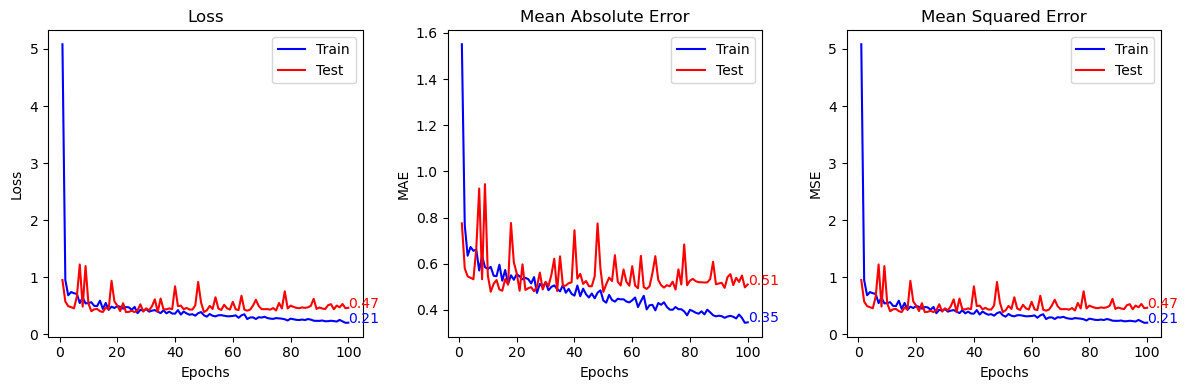

In [8]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

# Plot the loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Train')
plt.plot(epochs, test_losses, 'r', label='Test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(
	f'{train_losses[-1]:.2f}',
	xy=(epochs[-1], train_losses[-1]),
	xytext=(epochs[-1], train_losses[-1]),
	color='blue',
	arrowprops=None
)
plt.annotate(
	f'{test_losses[-1]:.2f}',
	xy=(epochs[-1], test_losses[-1]),
	xytext=(epochs[-1], test_losses[-1]),
	color='red',
	arrowprops=None
)

# Plot the MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, train_maes, 'b', label='Train')
plt.plot(epochs, test_maes, 'r', label='Test')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.annotate(
	f'{train_maes[-1]:.2f}',
	xy=(epochs[-1], train_maes[-1]),
	xytext=(epochs[-1], train_maes[-1]),
	color='blue',
	arrowprops=None
)
plt.annotate(
	f'{test_maes[-1]:.2f}',
	xy=(epochs[-1], test_maes[-1]),
	xytext=(epochs[-1], test_maes[-1]),
	color='red',
	arrowprops=None
)

# Plot the MSE
plt.subplot(1, 3, 3)
plt.plot(epochs, train_mses, 'b', label='Train')
plt.plot(epochs, test_mses, 'r', label='Test')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.annotate(
	f'{train_mses[-1]:.2f}',
	xy=(epochs[-1], train_mses[-1]),
	xytext=(epochs[-1], train_mses[-1]),
	color='blue',
	arrowprops=None
)
plt.annotate(
	f'{test_mses[-1]:.2f}',
	xy=(epochs[-1], test_mses[-1]),
	xytext=(epochs[-1], test_mses[-1]),
	color='red',
	arrowprops=None
)

plt.tight_layout()
plt.show()

## 7. Restore a model

In [17]:
model_path = f'./models/{dataset_name.split(".")[0]}_model.pth'
model = Model(x_train.shape[1], hidden_size, 1)
model.load_state_dict(torch.load(model_path, weights_only=True))
display(model)

Model(
  (relu): ReLU()
  (fc1): Linear(in_features=11, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

## 8. Make a prediction

In [25]:
# Pick random samples from the test set
rng = np.random.default_rng(int(time.time()))
indices = rng.choice(len(test_dataset), num_tests, replace=False)

# Predict the quality of the samples
model.eval()
print('Real\tPredicted\tError')
with torch.no_grad():
	for i in indices:
		x, y = test_dataset[i]
		y_hat = model(x).item()
		y = y.item()
		print(f'{y:.2f}\t{y_hat:.2f}\t\t{abs(y - y_hat):.2f}')

Real	Predicted	Error
6.00	5.30		0.70
6.00	6.36		0.36
5.00	5.93		0.93
6.00	5.75		0.25
6.00	5.43		0.57
7.00	7.09		0.09
6.00	5.75		0.25
6.00	5.91		0.09
5.00	4.92		0.08
5.00	5.20		0.20
